In [1]:
# 安装 Beautiful Soup
!pip install beautifulsoup4

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [95]:
# spider
import requests
from bs4 import BeautifulSoup
import re
import networkx as nx
import matplotlib.pyplot as plt

#站点类 
class Station :
    """
    name : 站点名
    line_lable : 所属线
    next_stations : 连接的站点
    """
    def __init__(self, name="", line_lable="", next_stations = []):
        self.name, self.line_lable, self.next_stations = name, line_lable, next_stations
        
    def setName(self, name="") : self.name = name
    def getName(self) : return self.name

    def setLineLable(self, line_lable="") : self.line_lable = line_lable
    def getLineLable(self) : return self.line_lable 
    
    def setNextStations(self, next_stations = []) : self.next_stations = next_stations
    def getNextStations(self) : return self.next_stations    
    
    def to_str(self) : 
        return "name = " + self.name + ",line_lable = " + self.line_lable + ",next_stations = " + str(self.next_stations)
    
# 请求头
def headers() : 
    header = {
     "User-Agent": "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.89 "
     "Safari/537.36"
     }
    return header

# 站点url
def source() : 
    return 'https://baike.baidu.com'

# 详情url
def contact_item(item) : 
    return source() + item

# 爬取源码
def spider(url, encode) : 
    header = headers()
    res = requests.get(url,  headers=header)
    res.encoding = encode
    soup = BeautifulSoup(res.text)
    return soup

# 地铁线 + 链接
def line_and_href(tables) : 
    lfs = {}
    for t in tables : 
        tds = t.find_all('td')
        for td in tds : 
            if re.findall(r'北京地铁.*线', str(td)) : 
                lfs[td.get_text()] = td.a.get('href')
    return lfs

# 获取所有地铁线及链接
def all_lfs(soup) : 
    tables = soup.find_all('table')
    pat = r"<tr><th.*>线路</th><th.*>起止点</th><th.*>首班</th><th>末班</th></tr><tr>"
    mts = [t for t in tables if re.findall(pat, str(t))]
    lfs = line_and_href(mts)
    return lfs

def stations(lfs) : 
    # 地铁路线
    lines = {}
    
    for k, v in lfs.items() : 
        preferred_pat = r"" + str(k[4:] + ".{0,6}首末班?车时[刻|间]表?").replace('(', '\(?').replace('（', '（?').replace(')', '\)?').replace('）', '）?')
        print("spider " + k)
        optional_pat = r"车站信息"
        special_pat = r"<tr><th.*>车?站?编号</th><th.*>车站名称.*</th>.*<tr>"
        soup = spider(contact_item(v), 'utf-8')
        tables = soup.find_all('table')
        
        tagets = [tab for tab in tables if re.findall(preferred_pat, str(tab))]
        if  len(tagets) > 0 :
            print(preferred_pat)
            trs = tagets[0].find_all('tr')
            stations = [list(tr.children)[0].get_text() for tr in trs[1:] if list(tr.children) and (not re.findall(r"参考|车站|时间|方向|全程|(备?注)|(\d{4}年\d{1,2}月)", str(tr)))]
            if re.findall(r"内|外环", str(trs[0])) : 
                print("环线")
                stations.append(stations[0])
            lines[k] = stations
            continue
            
        tagets = [tab for tab in tables if re.findall(optional_pat, str(tab))]
        if  len(tagets) > 0 : 
            print(optional_pat)
            trs = tagets[0].find_all('tr')
            stations = [list(tr.children)[1].get_text().replace("\n", "") for tr in trs[1:] if list(tr.children) and (not re.findall(r"参考|时间|方向|全程|(备?注)|(\d{4}年\d{1,2}月)", str(tr)))]
            if re.findall(r"内|外环", str(trs[0])) : 
                print("环线")
                stations.append(stations[0])
            lines[k] = stations
            continue
            
        tagets = [tab for tab in tables if re.findall(special_pat, str(tab))]
        if  len(tagets) > 0 : 
            print(special_pat)
            trs = tagets[0].find_all('tr')
            stations = [list(tr.children)[1].get_text().replace("\n", "") for tr in trs[1:] if list(tr.children) and (not re.findall(r"参考|时间|方向|全程|(备?注)", str(tr)))]
            if re.findall(r"[内外]环", str(trs[0])) : 
                print("环线")
                stations.append(stations[0])
            lines[k] = stations
            continue     

    return lines
            
# 生成地铁图
def create_line_graph(lines) : 
    gragh = {}
    # 生成所有站点信息    
    for line_lable,stations in lines.items() : 
        for station in stations : 
            s = Station(name=station, line_lable=line_lable, next_stations = [])
            if not station in gragh : 
                gragh[station] = s
    
    # 关联所有相邻站点
    for line_lable,stations in lines.items() : 
        for i, station in enumerate(stations) : 
            current_ = gragh[station]
            if i != 0 or i != len(stations) - 1 : 
                if i - 1 >= 0 : 
                    pre_station = stations[i - 1]
                    current_.setNextStations(current_.getNextStations() + [pre_station])
                
                if i + 1 <= len(stations) - 1 : 
                    next_station = stations[i + 1]
                    current_.setNextStations(current_.getNextStations() + [next_station])

    return gragh        

# 路线查询
def search(start, destination, gragh):
    pathes = [[start]]
    visitied = set()
    
    while pathes: # if we find existing pathes
        path = pathes.pop(0)
        froninter = path[-1]

        if froninter in visitied: continue
            
        successors = gragh[froninter].getNextStations()
        
        for station in successors:
            if station in path: continue  # eliminate loop
                
            new_path = path + [station]
            
            pathes.append(new_path)
            
            if station == destination: return new_path
        
        visitied.add(froninter)
        
    return pathes

# 打印路线
def print_line(line, graph) : 
    print(" ---> ".join([station + "🚇(" + graph[station].getLineLable() + ")" for station in line]))

In [53]:
soup = spider(contact_item('/item/北京地铁/408485'), 'utf-8')

In [54]:
lfs = all_lfs(soup)

In [61]:
lines = stations(lfs)

spider 北京地铁1号线
1号线.{0,6}首末班?车时[刻|间]表?
spider 北京地铁2号线
2号线.{0,6}首末班?车时[刻|间]表?
环线
spider 北京地铁4号线
4号线.{0,6}首末班?车时[刻|间]表?
spider 北京地铁5号线
5号线.{0,6}首末班?车时[刻|间]表?
spider 北京地铁6号线
6号线.{0,6}首末班?车时[刻|间]表?
spider 北京地铁7号线
7号线.{0,6}首末班?车时[刻|间]表?
spider 北京地铁8号线（北段）
8号线（?北段）?.{0,6}首末班?车时[刻|间]表?
spider 北京地铁8号线（南段）
8号线（?南段）?.{0,6}首末班?车时[刻|间]表?
spider 北京地铁9号线
9号线.{0,6}首末班?车时[刻|间]表?
spider 北京地铁10号线
10号线.{0,6}首末班?车时[刻|间]表?
环线
spider 北京地铁13号线
13号线.{0,6}首末班?车时[刻|间]表?
spider 北京地铁14号线（西段）
14号线（?西段）?.{0,6}首末班?车时[刻|间]表?
spider 北京地铁14号线（东段）
14号线（?东段）?.{0,6}首末班?车时[刻|间]表?
spider 北京地铁15号线
15号线.{0,6}首末班?车时[刻|间]表?
spider 北京地铁16号线
<tr><th.*>车?站?编号</th><th.*>车站名称.*</th>.*<tr>
spider 北京地铁八通线
八通线.{0,6}首末班?车时[刻|间]表?
spider 北京地铁昌平线
昌平线.{0,6}首末班?车时[刻|间]表?
spider 北京地铁亦庄线
车站信息
spider 北京地铁房山线
房山线.{0,6}首末班?车时[刻|间]表?
spider 北京地铁S1线
S1线.{0,6}首末班?车时[刻|间]表?
spider 北京地铁燕房线
<tr><th.*>车?站?编号</th><th.*>车站名称.*</th>.*<tr>


In [ ]:
# 北京地铁1号线 北京地铁1号线车站列表/北京地铁1号线首末车时刻表
# 北京地铁2号线 北京地铁2号线车站列表/北京地铁2号线首末车时间表
# 北京地铁4号线 北京地铁4号线车站列表/北京地铁4号线首末班车时刻表
# 北京地铁5号线 北京地铁5号线车站列表/5号线首末车时刻表
# 北京地铁6号线 北京地铁6号线车站列表/6号线首末车时刻表
# 北京地铁7号线 北京地铁7号线车站列表/7号线首末车时刻表
# 北京地铁8号线（北段）北京地铁8号线车站列表/北京地铁8号线（北段）首末车时刻表
# 北京地铁8号线（南段）北京地铁8号线车站列表/北京地铁8号线（南段）首末车时刻表
# 北京地铁9号线 北京地铁9号线车站列表/9号线首末车时刻表
# 北京地铁10号线 北京地铁10号线车站列表/10号线首末车时刻表
# 北京地铁13号线 车站列表/13号线首末车时刻表
# 北京地铁14号线（西段）北京地铁14号线车站列表/14号线（西段）首末车时刻表
# 北京地铁14号线（东段）北京地铁14号线车站列表/14号线东段（含中段）首末车时刻表
# 北京地铁15号线 北京地铁15号线车站列表/北京地铁15号线首末车时刻表
# 北京地铁16号线 车站列表/首末车时间
# 北京地铁八通线 北京地铁八通线车站列表/八通线首末车时刻表
# 北京地铁昌平线 北京地铁昌平线车站列表/昌平线首末车时刻表
# 北京地铁亦庄线 车站信息
# 北京地铁房山线 北京地铁房山线车站列表/房山线首末车时刻表
# 北京地铁S1线 车站列表/北京地铁S1线首末车时刻表
# 北京地铁燕房线 车站列表/运营时刻

In [62]:
lines

{'北京地铁1号线': ['苹果园',
  '古城',
  '八角游乐园',
  '八宝山',
  '玉泉路',
  '五棵松',
  '万寿路',
  '公主坟',
  '军事博物馆',
  '木樨地',
  '南礼士路',
  '复兴门',
  '西单',
  '天安门西',
  '天安门东',
  '王府井',
  '东单',
  '建国门',
  '永安里',
  '国贸',
  '大望路',
  '四惠',
  '四惠东'],
 '北京地铁2号线': ['西直门',
  '积水潭',
  '鼓楼大街',
  '安定门',
  '雍和宫',
  '东直门',
  '东四十条',
  '朝阳门',
  '建国门',
  '北京站',
  '崇文门',
  '前门',
  '和平门',
  '宣武门',
  '长椿街',
  '复兴门',
  '阜成门',
  '车公庄',
  '西直门'],
 '北京地铁4号线': ['安河桥北',
  '北宫门',
  '西苑',
  '圆明园',
  '北京大学东门',
  '中关村',
  '海淀黄庄',
  '人民大学',
  '魏公村',
  '国家图书馆',
  '动物园',
  '西直门',
  '新街口',
  '平安里',
  '西四',
  '灵境胡同',
  '西单',
  '宣武门',
  '菜市口',
  '陶然亭',
  '北京南站',
  '马家堡',
  '角门西',
  '公益西桥'],
 '北京地铁5号线': ['宋家庄',
  '刘家窑',
  '蒲黄榆',
  '天坛东门',
  '磁器口',
  '崇文门',
  '东单',
  '灯市口',
  '东四',
  '张自忠路',
  '北新桥',
  '雍和宫',
  '和平里北街',
  '和平西桥',
  '惠新西街南口',
  '惠新西街北口',
  '大屯路东',
  '北苑路北',
  '立水桥南',
  '立水桥',
  '天通苑南',
  '天通苑',
  '天通苑北'],
 '北京地铁6号线': ['金安桥',
  '苹果园',
  '杨庄',
  '西黄村',
  '廖公庄',
  '田村',
  '海淀五路居',
  '慈寿寺',
  '花园桥',
  '白石桥南',
  '车公庄西',
  '车公庄',
  '平安

In [6]:
def print_sub(lines) : 
    G = nx.Graph()
    for k, v in lines.items() : 
        i = 0
        while i < len(v) - 1 : 
            x = v[i]
            y = v[i + 1]
            G.add_edge(x, y, len="10.0")
            i += 1
    
    nx.draw(G, with_labels=True, node_size=60, font_size=15)
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.show()

/Users/yeah/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


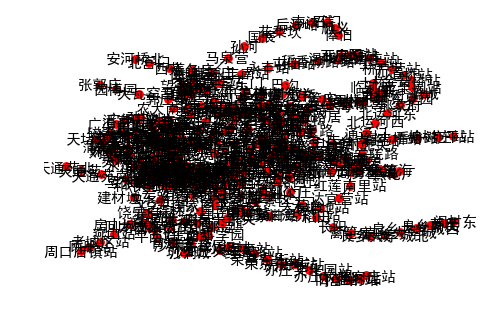

In [8]:
print_sub(lines)

In [63]:
line_graph = create_line_graph(lines)

In [64]:
line_graph['苹果园'].to_str()

"name = 苹果园,line_lable = 北京地铁1号线,next_stations = ['古城', '金安桥', '杨庄']"

In [65]:
line_graph['东单'].to_str()

"name = 东单,line_lable = 北京地铁1号线,next_stations = ['王府井', '建国门', '崇文门', '灯市口']"

In [66]:
line_graph['巴沟'].to_str()

"name = 巴沟,line_lable = 北京地铁10号线,next_stations = ['苏州街', '火器营']"

In [67]:
line_graph['西直门'].to_str()

"name = 西直门,line_lable = 北京地铁2号线,next_stations = ['积水潭', '车公庄', '动物园', '新街口', '明光桥西']"

In [74]:
line_graph['古城'].to_str()

"name = 古城,line_lable = 北京地铁1号线,next_stations = ['苹果园', '八角游乐园']"

In [84]:
search('苹果园', '东单', line_graph)

['苹果园',
 '古城',
 '八角游乐园',
 '八宝山',
 '玉泉路',
 '五棵松',
 '万寿路',
 '公主坟',
 '军事博物馆',
 '木樨地',
 '南礼士路',
 '复兴门',
 '西单',
 '天安门西',
 '天安门东',
 '王府井',
 '东单']

In [96]:
print_line(search('五棵松', '方庄', line_graph), line_graph)

五棵松🚇(北京地铁1号线) ---> 万寿路🚇(北京地铁1号线) ---> 公主坟🚇(北京地铁1号线) ---> 军事博物馆🚇(北京地铁1号线) ---> 北京西站🚇(北京地铁7号线) ---> 湾子🚇(北京地铁7号线) ---> 达官营🚇(北京地铁7号线) ---> 广安门内🚇(北京地铁7号线) ---> 菜市口🚇(北京地铁4号线) ---> 陶然亭🚇(北京地铁4号线) ---> 北京南站🚇(北京地铁4号线) ---> 永定门外🚇(北京地铁8号线（南段）) ---> 景泰🚇(北京地铁14号线（东段）) ---> 蒲黄榆🚇(北京地铁5号线) ---> 方庄🚇(北京地铁14号线（东段）)
